In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error,r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from catboost import CatBoostRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor

**LOADING DATASET**

In [ ]:
# Read dataset
data_path = '/content/HousingPrices-Amsterdam-August-2021.csv'
df = pd.read_csv(data_path)
df.head()

,Unnamed: 0,Address,Zip,Price,Area,Room,Lon,Lat
0,1,"Blasiusstraat 8 2, Amsterdam",1091 CR,685000.0,64,3,4.907736,52.356157
1,2,"Kromme Leimuidenstraat 13 H, Amsterdam",1059 EL,475000.0,60,3,4.850476,52.348586
2,3,"Zaaiersweg 11 A, Amsterdam",1097 SM,850000.0,109,4,4.944774,52.343782
3,4,"Tenerifestraat 40, Amsterdam",1060 TH,580000.0,128,6,4.789928,52.343712
4,5,"Winterjanpad 21, Amsterdam",1036 KN,720000.0,138,5,4.902503,52.410538


In [ ]:
# We drop redundant columns
df = df.drop(columns = ['Unnamed: 0', 'Address', 'Zip'], axis = 1)
df.head()

,Price,Area,Room,Lon,Lat
0,685000.0,64,3,4.907736,52.356157
1,475000.0,60,3,4.850476,52.348586
2,850000.0,109,4,4.944774,52.343782
3,580000.0,128,6,4.789928,52.343712
4,720000.0,138,5,4.902503,52.410538


In [ ]:
# Count the number of rows with at least one missing value
rows_with_missing_values = df[df.isnull().any(axis=1)].shape[0]

print(f"Number of rows with missing value: {rows_with_missing_values}")

Number of rows with missing value: 4


In [ ]:
# Calculate the percentage of rows with missing values
total_rows = df.shape[0]
percentage_missing_rows = (rows_with_missing_values / total_rows) * 100

print(f"Percentage of rows with missing value in the dataset: {percentage_missing_rows:.2f}%")

Percentage of rows with missing value in the dataset: 0.43%


In [ ]:
# Drop rows with any missing values
df_cleaned = df.dropna()

# Verify that there are no missing values left
print("\nCheck if the cleaned data contains any NaN:")
print(df_cleaned.isnull().sum())


Check if the cleaned data contains any NaN:
Price    0
Area     0
Room     0
Lon      0
Lat      0
dtype: int64


In [ ]:
# Checking duplicates and removing them
df_cleaned.duplicated().sum()

np.int64(3)

In [ ]:
df_cleaned = df_cleaned.drop_duplicates()

In [ ]:
df_cleaned.describe()

,Price,Area,Room,Lon,Lat
count,9.170000e+02,917.000000,917.000000,917.000000,917.000000
mean,6.231095e+05,95.708833,3.565976,4.888509,52.363351
std,5.395628e+05,56.904072,1.572574,0.052897,0.024043
min,1.750000e+05,21.000000,1.000000,4.644819,52.291519
25%,3.500000e+05,60.000000,3.000000,4.855835,52.352165
50%,4.690000e+05,83.000000,3.000000,4.886718,52.364636
75%,7.000000e+05,113.000000,4.000000,4.922210,52.377550
max,5.950000e+06,623.000000,14.000000,5.029122,52.423805


**REMOVE OUTLIERS BY IQR**

In [ ]:
# Create a copy of the DataFrame after dropping missing values and duplicates
Df = df_cleaned.copy() # Start from the dataframe after dropping missing values and duplicates and duplicates

print(f"Original shape before IQR outlier removal: {Df.shape}")

# Identify numerical columns for outlier removal (adjust if needed)
selected_cols = ['Price', 'Area', 'Room', 'Lon', 'Lat']

# Calculate bounds for all specified numerical columns
outlier_bounds = {}
for col in selected_cols:
    if col in Df.columns:
        Q1 = Df[col].quantile(0.25)
        Q3 = Df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outlier_bounds[col] = (lower_bound, upper_bound)

# Filter out outliers using the calculated bounds
# This creates a boolean mask where True indicates the row should be kept
mask = pd.Series(True, index=Df.index)
for col, (lower_bound, upper_bound) in outlier_bounds.items():
    mask = mask & (Df[col] >= lower_bound) & (Df[col] <= upper_bound)

Df = Df[mask]

print(f"Shape after IQR outlier removal: {Df.shape}")

# Display descriptive statistics for the new DataFrame after IQR outlier removal
print("\nDescriptive statistics after IQR outlier removal:")
display(Df.describe())

Original shape before IQR outlier removal: (917, 5)
Shape after IQR outlier removal: (731, 5)

Descriptive statistics after IQR outlier removal:


,Price,Area,Room,Lon,Lat
count,7.310000e+02,731.000000,731.000000,731.000000,731.000000
mean,5.001962e+05,80.361149,3.169631,4.885403,52.365215
std,2.119936e+05,29.480726,0.907326,0.049675,0.019971
min,1.790000e+05,25.000000,2.000000,4.774348,52.316165
25%,3.500000e+05,58.000000,3.000000,4.852521,52.353258
50%,4.390000e+05,78.000000,3.000000,4.884292,52.365104
75%,6.000000e+05,98.000000,4.000000,4.920411,52.377961
max,1.200000e+06,180.000000,5.000000,5.016555,52.414920


In [ ]:
Df

,Price,Area,Room,Lon,Lat
0,685000.0,64,3,4.907736,52.356157
1,475000.0,60,3,4.850476,52.348586
2,850000.0,109,4,4.944774,52.343782
4,720000.0,138,5,4.902503,52.410538
5,450000.0,53,2,4.875024,52.382228
...,...,...,...,...,...
916,525000.0,59,4,4.880977,52.368961
920,350000.0,72,3,4.890612,52.414587
921,350000.0,51,3,4.856935,52.363256
922,599000.0,113,4,4.965731,52.375268


**EXPLORATORY DATA ANALYSIS**

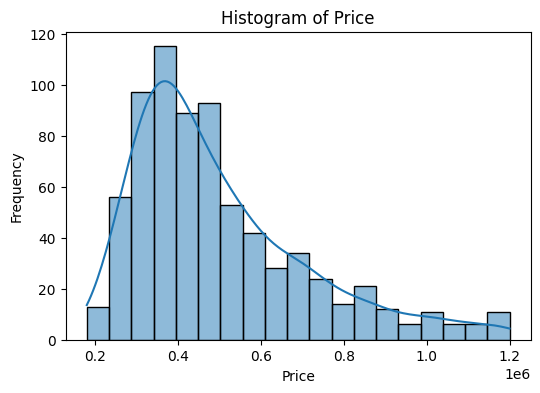

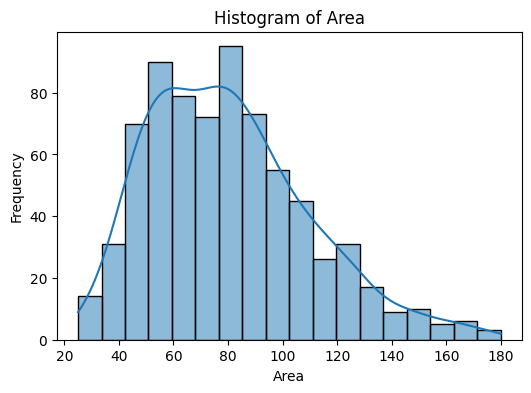

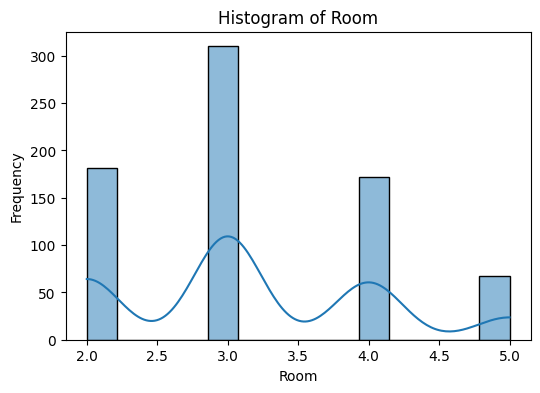

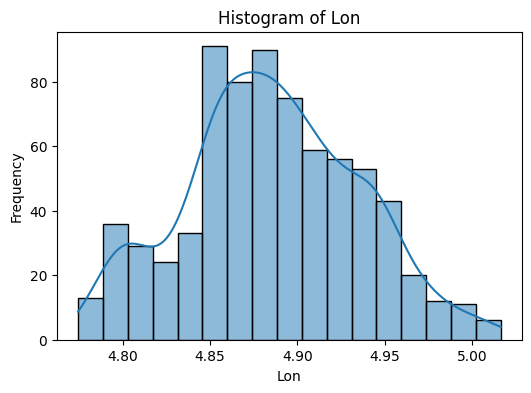

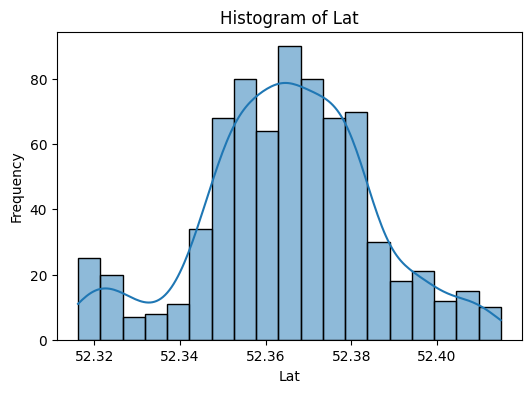

In [ ]:
# Plotting histograms for all columns in df_cleaned
for col in Df.columns:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=Df, x=col, kde=True)
    plt.title(f'Histogram of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()

In [ ]:
# Calculate the correlation matrix
correlation_matrix = Df.corr()

# Display the correlation matrix
print("Correlation Matrix:")
display(correlation_matrix)

Correlation Matrix:


,Price,Area,Room,Lon,Lat
Price,1.000000,0.713713,0.413550,0.062718,0.019741
Area,0.713713,1.000000,0.683800,0.040034,-0.021439
Room,0.413550,0.683800,1.000000,-0.022513,0.032268
Lon,0.062718,0.040034,-0.022513,1.000000,-0.046324
Lat,0.019741,-0.021439,0.032268,-0.046324,1.000000


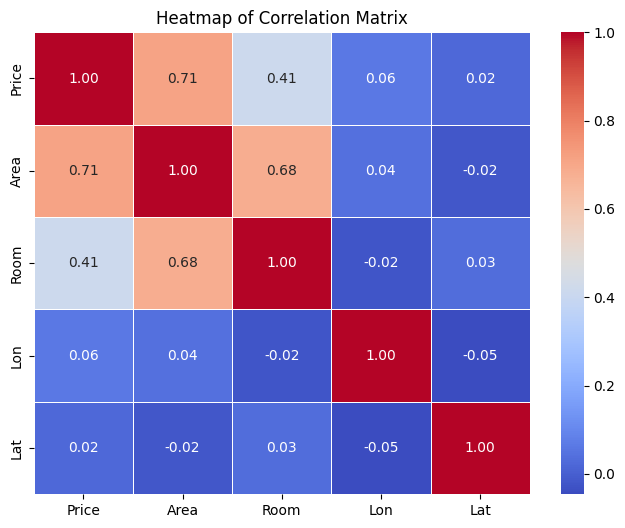

In [ ]:
# Plotting a heatmap of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Heatmap of Correlation Matrix')
plt.show()

Clearly, Area and Room strongly affect Price while Lon and Lat weakly affect Price.

**SPLITTING DATA**

In [ ]:
X = Df.drop(columns=['Price'])
y = Df['Price']

In [ ]:
X.shape
X

,Area,Room,Lon,Lat
0,64,3,4.907736,52.356157
1,60,3,4.850476,52.348586
2,109,4,4.944774,52.343782
4,138,5,4.902503,52.410538
5,53,2,4.875024,52.382228
...,...,...,...,...
916,59,4,4.880977,52.368961
920,72,3,4.890612,52.414587
921,51,3,4.856935,52.363256
922,113,4,4.965731,52.375268


In [ ]:
y.shape
y

,Price
0,685000.0
1,475000.0
2,850000.0
4,720000.0
5,450000.0
...,...
916,525000.0
920,350000.0
921,350000.0
922,599000.0


In [ ]:
# Split data for train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((584, 4), (147, 4), (584,), (147,))

**BUILDING MODEL**

In [ ]:
# Initialize the models
linear_reg = LinearRegression()
ridge_reg = Ridge(random_state=42)
lasso_reg = Lasso(random_state=42)
elastic_net = ElasticNet(random_state=42)
xgb_reg = xgb.XGBRegressor(random_state=42)
catboost_reg = CatBoostRegressor(random_state=42, verbose=0) # verbose=0 to suppress output
lgbm_reg = lgb.LGBMRegressor(random_state=42)

# Dictionary to store models
models_list = {
    "Linear Regression": linear_reg,
    "Ridge": ridge_reg,
    "Lasso": lasso_reg,
    "Elastic Net": elastic_net,
    "XGBoost": xgb_reg,
    "CatBoost": catboost_reg,
    "LightGBM": lgbm_reg
}

# Dictionary to store evaluation results
results_list = {}

print("--- Training and Evaluating Multiple Regression Models ---")

for name, model in models_list.items():
    print(f"\nTraining {name}...")
    try:
        # Train the model
        model.fit(X_train, y_train)

        # Make predictions on the test set
        y_pred = model.predict(X_test)

        # Evaluate the model
        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_test, y_pred)

        # Store the results
        results_list[name] = {
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "R^2": r2
        }

        # Print the evaluation metrics
        print(f"Evaluation metrics for {name}:")
        print(f"  MAE: {mae:.2f}")
        print(f"  MSE: {mse:.2f}")
        print(f"  RMSE: {rmse:.2f}")
        print(f"  R^2: {r2:.4f}")

    except Exception as e:
        print(f"An error occurred during training/evaluation of {name}: {e}")
        results_list[name] = {"Error": str(e)}


print("\n--- Training and Evaluation Complete ---")

# Optionally, display all results in a DataFrame for easy comparison
print("\n--- Summary of All Model Results ---")
results_df = pd.DataFrame(results_list).T # Transpose the DataFrame for better readability
display(results_df)

--- Training and Evaluating Multiple Regression Models ---

Training Linear Regression...
Evaluation metrics for Linear Regression:
  MAE: 106274.05
  MSE: 18163761126.73
  RMSE: 134773.00
  R^2: 0.5013

Training Ridge...
Evaluation metrics for Ridge:
  MAE: 106127.55
  MSE: 18221849012.51
  RMSE: 134988.33
  R^2: 0.4997

Training Lasso...
Evaluation metrics for Lasso:
  MAE: 106272.07
  MSE: 18163785848.38
  RMSE: 134773.09
  R^2: 0.5013

Training Elastic Net...
Evaluation metrics for Elastic Net:
  MAE: 105968.60
  MSE: 18040777207.56
  RMSE: 134315.96
  R^2: 0.5047

Training XGBoost...
Evaluation metrics for XGBoost:
  MAE: 64122.68
  MSE: 8402700559.76
  RMSE: 91666.25
  R^2: 0.7693

Training CatBoost...
Evaluation metrics for CatBoost:
  MAE: 53611.31
  MSE: 6593819476.15
  RMSE: 81202.34
  R^2: 0.8190

Training LightGBM...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhea

,MAE,MSE,RMSE,R^2
Linear Regression,106274.053396,1.816376e+10,134772.998508,0.501303
Ridge,106127.549212,1.822185e+10,134988.329171,0.499708
Lasso,106272.069692,1.816379e+10,134773.090223,0.501302
Elastic Net,105968.604075,1.804078e+10,134315.960360,0.504679
XGBoost,64122.682292,8.402701e+09,91666.245477,0.769299
CatBoost,53611.305389,6.593819e+09,81202.336642,0.818963
LightGBM,59272.882179,7.500059e+09,86602.880520,0.794081


# Task
Now we tuning the hyperparameters for CatBoost, XGBoost and LightGBM.

## Tuning hyperparameters for catboost


Define the parameter grid for CatBoostRegressor, initialize GridSearchCV, and perform the hyperparameter search on the training data.



In [ ]:
# Define the parameter grid for CatBoostRegressor
catboost_param_grid = {
    'iterations': [100, 250, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5]
}

# Initialize CatBoostRegressor
catboost = CatBoostRegressor(random_state=42, verbose=0)

# Initialize GridSearchCV
grid_search_catboost = GridSearchCV(estimator=catboost, param_grid=catboost_param_grid,
                                    cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search_catboost.fit(X_train, y_train)

# Get the best parameters
best_params_catboost = grid_search_catboost.best_params_
print("Best parameters for CatBoost:", best_params_catboost)

Best parameters for CatBoost: {'depth': 6, 'iterations': 250, 'l2_leaf_reg': 1, 'learning_rate': 0.05}


Train a CatBoost model with the best parameters found and evaluate its performance on the test set.



In [ ]:
# Train a new CatBoostRegressor model using the best parameters
best_catboost_model = CatBoostRegressor(**best_params_catboost, random_state=42, verbose=0)
best_catboost_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_catboost = best_catboost_model.predict(X_test)

# Evaluate the performance of the best CatBoost model
mae_catboost = mean_absolute_error(y_test, y_pred_catboost)
mse_catboost = mean_squared_error(y_test, y_pred_catboost)
rmse_catboost = np.sqrt(mse_catboost)
r2_catboost = r2_score(y_test, y_pred_catboost)

print("\nEvaluation metrics for Tuned CatBoost:")
print(f"  MAE: {mae_catboost:.2f}")
print(f"  MSE: {mse_catboost:.2f}")
print(f"  RMSE: {rmse_catboost:.2f}")
print(f"  R^2: {r2_catboost:.4f}")


Evaluation metrics for Tuned CatBoost:
  MAE: 53058.11
  MSE: 6301479097.77
  RMSE: 79381.86
  R^2: 0.8270


## Tuning hyperparameters for xgboost




Define the parameter grid for XGBoost, initialize the model, and set up and fit GridSearchCV to find the best parameters.



In [ ]:
# Define the parameter grid for XGBoostRegressor
xgb_param_grid = {
    'n_estimators': [100, 250, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.9, 1.0]
}

# Initialize XGBoostRegressor
xgb_reg = xgb.XGBRegressor(random_state=42)

# Initialize GridSearchCV
grid_search_xgb = GridSearchCV(estimator=xgb_reg, param_grid=xgb_param_grid,
                               cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search_xgb.fit(X_train, y_train)

# Print the best parameters
print("Best parameters for XGBoost:", grid_search_xgb.best_params_)

Best parameters for XGBoost: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 250, 'subsample': 0.7}


**Reasoning**:
Train a new XGBoost model using the best parameters found and evaluate its performance on the test set by calculating and printing the MAE, MSE, RMSE, and R^2 metrics.



In [ ]:
# Train a new XGBoostRegressor model using the best parameters
best_xgb_model = xgb.XGBRegressor(**grid_search_xgb.best_params_, random_state=42)
best_xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb = best_xgb_model.predict(X_test)

# Evaluate the performance of the best XGBoost model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("\nEvaluation metrics for Tuned XGBoost:")
print(f"  MAE: {mae_xgb:.2f}")
print(f"  MSE: {mse_xgb:.2f}")
print(f"  RMSE: {rmse_xgb:.2f}")
print(f"  R^2: {r2_xgb:.4f}")


Evaluation metrics for Tuned XGBoost:
  MAE: 58729.40
  MSE: 7195903730.46
  RMSE: 84828.67
  R^2: 0.8024


## Tuning hyperparameters for lightgbm


Define the parameter grid for LGBMRegressor, initialize the model, and set up and fit GridSearchCV to find the best parameters. Then train the best model and evaluate it on the test set. Finally, print the best parameters and evaluation metrics.



In [ ]:
# Define the parameter grid for LGBMRegressor
lgbm_param_grid = {
    'n_estimators': [100, 250, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [31, 50, 70],
    'max_depth': [-1, 10, 20]
}

# Initialize LGBMRegressor
lgbm_reg = LGBMRegressor(random_state=42)

# Initialize GridSearchCV
grid_search_lgbm = GridSearchCV(estimator=lgbm_reg, param_grid=lgbm_param_grid,
                                cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV to the training data
grid_search_lgbm.fit(X_train, y_train)

# Get the best parameters
best_params_lgbm = grid_search_lgbm.best_params_
print("Best parameters for LightGBM:", best_params_lgbm)

# Train a new LGBMRegressor model using the best parameters
best_lgbm_model = LGBMRegressor(**best_params_lgbm, random_state=42)
best_lgbm_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lgbm = best_lgbm_model.predict(X_test)

# Evaluate the performance of the best LightGBM model
mae_lgbm = mean_absolute_error(y_test, y_pred_lgbm)
mse_lgbm = mean_squared_error(y_test, y_pred_lgbm)
rmse_lgbm = np.sqrt(mse_lgbm)
r2_lgbm = r2_score(y_test, y_pred_lgbm)

print("\nEvaluation metrics for Tuned LightGBM:")
print(f"  MAE: {mae_lgbm:.2f}")
print(f"  MSE: {mse_lgbm:.2f}")
print(f"  RMSE: {rmse_lgbm:.2f}")
print(f"  R^2: {r2_lgbm:.4f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 496
[LightGBM] [Info] Number of data points in the train set: 584, number of used features: 4
[LightGBM] [Info] Start training from score 504667.851027
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

## Summary

Create a DataFrame to store the evaluation results and populate it with the pre-tuned model results from `results_list`.



In [ ]:
# Create a DataFrame to store the evaluation results
results_summary_df = pd.DataFrame(results_list)

# Transpose the DataFrame for better readability and rename the index
results_summary_df = results_summary_df.T.rename_axis("Model")

print("Evaluation results before tuning:")
display(results_summary_df)

Evaluation results before tuning:


,MAE,MSE,RMSE,R^2
Model,,,,
Linear Regression,106274.053396,1.816376e+10,134772.998508,0.501303
Ridge,106127.549212,1.822185e+10,134988.329171,0.499708
Lasso,106272.069692,1.816379e+10,134773.090223,0.501302
Elastic Net,105968.604075,1.804078e+10,134315.960360,0.504679
XGBoost,64122.682292,8.402701e+09,91666.245477,0.769299
CatBoost,53611.305389,6.593819e+09,81202.336642,0.818963
LightGBM,59272.882179,7.500059e+09,86602.880520,0.794081


The evaluation results for the tuned CatBoost, XGBoost, and LightGBM models to the results DataFrame.


In [ ]:
# Summary
results_summary_df.loc['CatBoost (Tuned)'] = {
    'MAE': mae_catboost,
    'MSE': mse_catboost,
    'RMSE': np.sqrt(mse_catboost),
    'R^2': r2_catboost
}

results_summary_df.loc['XGBoost (Tuned)'] = {
    'MAE': mae_xgb,
    'MSE': mse_xgb,
    'RMSE': np.sqrt(mse_xgb),
    'R^2': r2_xgb
}

results_summary_df.loc['LightGBM (Tuned)'] = {
    'MAE': mae_lgbm,
    'MSE': mse_lgbm,
    'RMSE': np.sqrt(mse_lgbm),
    'R^2': r2_lgbm
}

print("Evaluation results before and after tuning:")
display(results_summary_df)

Evaluation results before and after tuning:


,MAE,MSE,RMSE,R^2
Model,,,,
Linear Regression,106274.053396,1.816376e+10,134772.998508,0.501303
Ridge,106127.549212,1.822185e+10,134988.329171,0.499708
Lasso,106272.069692,1.816379e+10,134773.090223,0.501302
Elastic Net,105968.604075,1.804078e+10,134315.960360,0.504679
XGBoost,64122.682292,8.402701e+09,91666.245477,0.769299
CatBoost,53611.305389,6.593819e+09,81202.336642,0.818963
LightGBM,59272.882179,7.500059e+09,86602.880520,0.794081
CatBoost (Tuned),53058.106191,6.301479e+09,79381.856225,0.826989
XGBoost (Tuned),58729.398916,7.195904e+09,84828.672809,0.802432


--- Summary of Model Performance Before and After Tuning ---

Comparison of models:
- The linear models (Linear Regression, Ridge, Lasso, Elastic Net) have significantly lower R^2 values (around 0.50) compared to the boosting models, indicating poorer performance.
- Among the initial boosting models, CatBoost had the best performance (highest R^2, lowest MAE, MSE, RMSE).

Impact of Hyperparameter Tuning on Boosting Models:
- CatBoost: Tuning resulted in a slight improvement in R^2 (from 0.8190 to 0.8270), and reductions in MAE, MSE, and RMSE.
- XGBoost: Tuning led to an improvement in R^2 (from 0.7693 to 0.8024), and reductions in error metrics.
- LightGBM: Tuning also improved R^2 (from 0.7941 to 0.8045), and reduced error metrics.

Overall Best Performing Model:
- After tuning, CatBoost (Tuned) still demonstrates the best performance with the highest R^2 and lowest error metrics among all evaluated models.

## Stacking

In [ ]:
# Define the base models using the best tuned models
estimators = [
    ('catboost', best_catboost_model),
    ('xgboost', best_xgb_model),
    ('lightgbm', best_lgbm_model)
]

# Initialize StackingRegressor
stacking_reg = StackingRegressor(estimators=estimators, final_estimator=Ridge(random_state=42))

# Train the StackingRegressor model
print("Training Stacking Regressor...")
stacking_reg.fit(X_train, y_train)
print("Stacking Regressor training complete.")

# Make predictions on the test set
y_pred_stacked = stacking_reg.predict(X_test)

# Evaluate the StackingRegressor model
mae_stacked = mean_absolute_error(y_test, y_pred_stacked)
mse_stacked = mean_squared_error(y_test, y_pred_stacked)
rmse_stacked = np.sqrt(mse_stacked)
r2_stacked = r2_score(y_test, y_pred_stacked)

# Print the evaluation metrics
print("\nEvaluation metrics for Stacking Regressor:")
print(f"  MAE: {mae_stacked:.2f}")
print(f"  MSE: {mse_stacked:.2f}")
print(f"  RMSE: {rmse_stacked:.2f}")
print(f"  R^2: {r2_stacked:.4f}")

Training Stacking Regressor...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000054 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 496
[LightGBM] [Info] Number of data points in the train set: 584, number of used features: 4
[LightGBM] [Info] Start training from score 504667.851027
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fu

In [ ]:
# Summary
results_summary_df.loc['Stacking Regressor'] = {
    'MAE': mae_stacked,
    'MSE': mse_stacked,
    'RMSE': rmse_stacked,
    'R^2': r2_stacked
}

print("\nEvaluation results with Stacking Regressor:")
display(results_summary_df)


Evaluation results with Stacking Regressor:


,MAE,MSE,RMSE,R^2
Model,,,,
Linear Regression,106274.053396,1.816376e+10,134772.998508,0.501303
Ridge,106127.549212,1.822185e+10,134988.329171,0.499708
Lasso,106272.069692,1.816379e+10,134773.090223,0.501302
Elastic Net,105968.604075,1.804078e+10,134315.960360,0.504679
XGBoost,64122.682292,8.402701e+09,91666.245477,0.769299
CatBoost,53611.305389,6.593819e+09,81202.336642,0.818963
LightGBM,59272.882179,7.500059e+09,86602.880520,0.794081
CatBoost (Tuned),53058.106191,6.301479e+09,79381.856225,0.826989
XGBoost (Tuned),58729.398916,7.195904e+09,84828.672809,0.802432


## Summary:

### Data Analysis Key Findings

*   The best hyperparameters for CatBoost were identified as `{'depth': 6, 'iterations': 250, 'l2_leaf_reg': 1, 'learning_rate': 0.05}`, resulting in an R² of 0.8270 on the test set.
*   The best hyperparameters for XGBoost were found to be `{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 250, 'subsample': 0.7}`, yielding an R² of 0.8024 on the test set.
*   The optimal hyperparameters for LightGBM were `{'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 500, 'num_leaves': 31}`, achieving an R² of 0.8045 on the test set.
*   Hyperparameter tuning improved the performance of all three boosting models compared to their untuned versions.
*   After tuning, CatBoost demonstrated the best performance among the individual boosting models with the highest R² (0.8270) and lowest error metrics.
*   A Stacking Regressor using the tuned CatBoost, XGBoost, and LightGBM models as base estimators was built and evaluated. Its R² is 0.8190, slightly below best CatBoost model's performance.

